# Выбор локации для нефтяной скважины

Заказчик проекта - нефтедобывающая компания. По представленным данным нужно определить оптимально месторождение для разработки.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Задача - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль и  проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Обзор данных

In [2]:
import pandas as pd 
import seaborn as sns
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
display(df_0.head(3))
df_0.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
display(df_1.head(3))
df_1.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
df_2 = pd.read_csv('/datasets/geo_data_2.csv')
display(df_2.head(3))
df_2.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В таблицах по 5 столбцов. Тип данных в столбцах — строки и вещественные числа, пропуски отсутствуют.

Согласно документации к данным:

- `id` — уникальный идентификатор скважины;
- `f0, f1, f2` — три признака точек
- `product` — объём запасов в скважине (тыс. баррелей).


### Предобработка данных

Проверим данные на наличие полных дубликатов:

In [6]:
print(df_0.duplicated().sum())
print(df_1.duplicated().sum())
print(df_2.duplicated().sum())

0
0
0


Теперь проверим на дубликаты по id:

In [7]:
print('Доля дубликатов в регионе geo_data_0: ', df_0['id'].duplicated().sum()/len(df_0))
print('Доля дубликатов в регионе geo_data_1: ', df_1['id'].duplicated().sum()/len(df_1))
print('Доля дубликатов в регионе geo_data_2: ', df_2['id'].duplicated().sum()/len(df_2))

Доля дубликатов в регионе geo_data_0:  0.0001
Доля дубликатов в регионе geo_data_1:  4e-05
Доля дубликатов в регионе geo_data_2:  4e-05


Дубликаты присутствуют, у них одинаковый id, но разные данные. Т.к их доля очень мала, можем удалить эти значения:

In [8]:
df_0 = df_0.drop_duplicates(subset=['id'])
df_1 = df_1.drop_duplicates(subset=['id'])
df_2 = df_2.drop_duplicates(subset=['id'])

## Обучение и проверка модели

### Изучение признаков

С помощью тепловой карты посмотрим на взаимосвязь признаков:

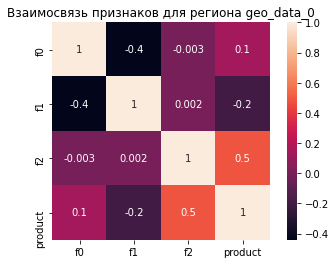

In [9]:
sns.heatmap(df_0.corr(), annot=True, fmt='.1g', square=True)
plt.title('Взаимосвязь признаков для региона geo_data_0')
plt.show() 

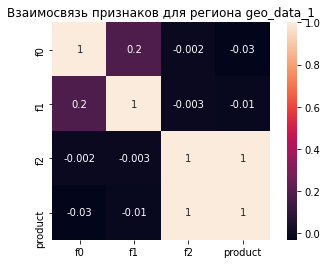

In [10]:
sns.heatmap(df_1.corr(), annot=True, fmt='.1g', square=True)
plt.title('Взаимосвязь признаков для региона geo_data_1')
plt.show()

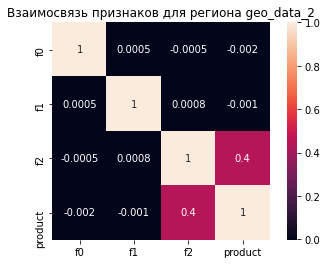

In [11]:
sns.heatmap(df_2.corr(), annot=True, fmt='.1g', square=True)
plt.title('Взаимосвязь признаков для региона geo_data_2')
plt.show() 

Для региона geo_data_1 видим странное значение корреляции целевого признака от f2 равное единице, это может быть вызвано ошибкой в данных. Значения же корреляции для регионов geo_data_0 и geo_data_2 похожи, зависмость не сильная, в наибольшей степени на целевой признак `product` влияет признак `f2`. 

### Разбиение данных на выборки и обучение модели

По условию задачи, для обучения модели будет использоваться только линейная регрессия, из-за недостаточной предсказуемости остальных.

In [12]:
model = LinearRegression()

Разбивать данные на выборки и получать предсказания модели и RMSE будем с помощью функции:

In [13]:
def predictions_rmse(df):
    features = df.drop(['id', 'product'], axis = 1)
    target = df['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, predicted_valid))**0.5
    print('средний запас сырья в регионе: ', predicted_valid.mean())
    print('RMSE: ', rmse)
    return predicted_valid, target_valid

In [14]:
print('Для региона geo_data_0:')
predicted_0, target_0 = predictions_rmse(df_0)
print('------------------')
print('Для региона geo_data_1:')
predicted_1, target_1 = predictions_rmse(df_1)
print('------------------')
print('Для региона geo_data_2:')
predicted_2, target_2 = predictions_rmse(df_2)

Для региона geo_data_0:
средний запас сырья в регионе:  92.78915638280621
RMSE:  37.853527328872964
------------------
Для региона geo_data_1:
средний запас сырья в регионе:  69.17831957030432
RMSE:  0.892059264771703
------------------
Для региона geo_data_2:
средний запас сырья в регионе:  94.86572480562035
RMSE:  40.07585073246016


Наименьшую RMSE видим в регионе geo_data_1, но скорее всего такое значение обусловлено обнаруженными выше подозрительными значеними признака f2. Средний запас сырья больше всего в регионах geo_data_0 и geo_data_1, но значение RMSE здесь очень велико.

## Подготовка к расчёту прибыли

Сохраним в  отдельных переменных все ключевые значения для расчётов.

In [15]:
POINTS_NUM = 500       # общее число скважин для исследования
BEST_POINTS_NUM = 200  # число скважин в одном регионе для разработки
BUDGET = 10*(10**9)   # бюджет на разработку скважин в регионе
INCOME = 450000        # доход с каждой единицы продукта
RISK_MAX = 0.025       # максимальная вероятность убытков

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [16]:
BUDGET / BEST_POINTS_NUM / INCOME

111.11111111111111

Согласно полученным выше значениям среднего запаса сырья по регионам, ни в одном регионе нет достаточного количества для безубыточной разработки, но по условию задачи нужно исследовать 500 скважин и выбрать 200 лучших. Для этого определим функцию income_calc:

In [17]:
def income_calc(target, predicted):
    target = pd.Series(target).reset_index(drop=True)
    predicted = pd.Series(predicted).reset_index(drop=True)
    pred_sorted = predicted.sort_values(ascending=False)
    selected = target[pred_sorted.index][:BEST_POINTS_NUM]
    return INCOME * selected.sum() - BUDGET

In [21]:
check = income_calc(target_0, predicted_0)
check

3365187237.700287

Для оценки рисков определим функцию bootstrap:

In [ ]:
def bootstrap(target, predicted):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=POINTS_NUM, replace=True, random_state=state)
        predicted = pd.Series(predicted)
        pred_subsample = predicted[target_subsample.index]
        res = income_calc(target_subsample, pred_subsample)
        values.append(res)
    values = pd.Series(values)

    lower = values.quantile(.025)
    upper = values.quantile(.975)
    mean = values.mean() 
    risks = (values < 0).mean() * 100   
    print('Средняя выручка:', round(mean/1000000), 'млн.р.')
    print('2.5%-квантиль:', round(lower/1000000), 'млн.р')
    print('Доверительный интервал:  от', round(lower/1000000), 'до', round(upper/1000000), 'млн.р')
    print('Bероятность убытков:', risks, '%')

## Расчёт прибыли и рисков 

С помощью функции рассчитаем вероятность убытков для каждого из регионов:

In [ ]:
print('Для региона geo_data_0:')
bootstrap(target_0, predicted_0)
print('--------------')
print('Для региона geo_data_1:')
bootstrap(target_1, predicted_1)
print('--------------')
print('Для региона geo_data_2:')
bootstrap(target_2, predicted_2)

Таким образом, в обозначенную границу вероятности убытков менее 2.5% попадает только регион geo_data_1. Также этот регион показывает наибольшую среднюю выручку в 478 млн.р. Однако, стоит учитывать, что в этом регионе мы обнаружили необычное значение признака f2, сильно коррелирующее с объемом продукта.  

## Общий вывод

По итогам исследования для разработки рекомендуется регион geo_data_1:
 - вероятность убытков до 1.2%
 - средняя прибыль имеет наибольшее значение среди остальных регонов.